# Mask R-CNN and Dataset Processing Inspector

Inspect and visualize data loading, pre-processing code and MASK R-CNN configuration.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
matplotlib.use('TkAgg')

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

import utils
import visualize
from visualize import display_images
import model as modellib
from config import Config
from model import log

%matplotlib inline

/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/s

## Load Dataset

In [3]:
import csv
import dataset

# Load class map - these tables map the original TACO classes to your desired class system
# and allow you to discard classes that you don't want to include.
class_map = {}
with open("./taco_config/map_1.csv") as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]:row[1] for row in reader}

# Load full dataset or a subset
TACO_DIR = "../data"
round = None # Split number: If None, loads full dataset else if int > 0 selects split no 
subset = "train" # Used only when round !=None, Options: ('train','val','test') to select respective subset
dataset = dataset.Taco()
taco = dataset.load_taco(TACO_DIR, round, subset, class_map=class_map, return_taco=True)

# Must call before using the dataset
dataset.prepare()

print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

creating index...
index created!
Number of images used: 1500
Class Count: 2
  0. BG                                                
  1. Litter                                            


## Visualize class balance

In [4]:
import seaborn as sns
import pandas as pd

# Count annotations
cat_histogram = np.zeros(dataset.num_classes,dtype=int)
class_names = []
for i, info in enumerate(dataset.class_info):
    ann_per_cat = taco.getAnnIds(catIds=i, iscrowd=None)
    cat_histogram[i] = len(ann_per_cat)
    class_names.append(info['name'])

# Initialize the matplotlib figure
_, ax = plt.subplots(figsize=(5,1*dataset.num_classes))

# Convert to DataFrame
d ={'Categories': class_names, 'Number of annotations': cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b", orient="h")

fig = plot_1.get_figure()
fig.show()

/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


# Image stats

Before deciding your network configuration, it's a good idea look into the following statistics

In [5]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for img in taco.dataset['images']:
    key = str(img['width'])+'-'+str(img['height'])
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(img['width'])
        heights.append(img['height'])
        shape_freqs.append(1)

d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plot = plot.set_title('Number of images per image shape',fontsize=15)

In [6]:
nr_annotation_per_image = []
for img in taco.dataset['images']:
    annIds = taco.getAnnIds(imgIds=img['id'], catIds=[])
    nr_annotation_per_image.append(len(annIds))

plt.figure(figsize=(20,4))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100)
ax.set_yscale('log')
ax.set(xlabel='Number of annotations per image', ylabel='Image Count')

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 3.1893333333333334


In [7]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
bbox_aspect_ratio = []
max_image_dim = 1024

for ann in taco.dataset['annotations']:
    
    imgs = taco.loadImgs(ann['image_id'])
    
    resize_scale = max_image_dim/max(imgs[0]['width'], imgs[0]['height'])
    # Uncomment this to work on original image size
#     resize_scale = 1
    
    bbox_widths.append(ann['bbox'][2]*resize_scale)
    bbox_heights.append(ann['bbox'][3]*resize_scale)
    obj_area = ann['bbox'][2]*ann['bbox'][3]*resize_scale**2 # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    img_area = imgs[0]['width']*imgs[0]['height']*resize_scale**2
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    
print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<96*96 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(20,4))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200)
ax.set_yscale('log')
ax = ax.set(xlabel=r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', ylabel='Number of annotations')

plt.figure(figsize=(20,4))
ax = sns.distplot(np.maximum(np.array(bbox_widths),np.array(bbox_heights)),kde=False, bins=200)
ax = ax.set(xlabel='Maximum bbox dimension', ylabel='Number of annotations')

import colorsys
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", palette = cmap,data=df)

print('Number of bboxes smaller than 1024:',np.sum(np.array(bbox_widths)<1024))
print('Number of bboxes larger than 1024:',np.sum(np.array(bbox_widths)>1024))

# anchors = [(32,32),(64,64),(128,128),(256,256),(512,512)]
scales, ratios = np.meshgrid(np.array([16,32,64,128,256,512]), np.array([0.5,1,2]))
scales = scales.flatten()
ratios = ratios.flatten()
# Enumerate heights and widths from scales and ratios
anchor_heights = scales / np.sqrt(ratios)
anchor_widths = scales * np.sqrt(ratios)

IoUs = []
for i in range(len(bbox_widths)):
    bbox_area = bbox_widths[i]*bbox_heights[i]
    IoU_max = 0.0
    for j in range(len(anchor_heights)):
        anchor_area = anchor_heights[j]*anchor_widths[j]
        intersection_area = min(anchor_widths[j],bbox_widths[i])*min(anchor_heights[j], bbox_heights[i])
        IoU = intersection_area / (bbox_area + anchor_area - intersection_area)
        if IoU>0.5:
            IoU_max = IoU
    IoUs.append(IoU_max)
    
print('Number of missing annotations', np.sum(np.array(IoUs)==0.0))
  
# Plotting bbox dims
d ={'BBox width (px)': bbox_widths, 'BBox height (px)': bbox_heights, 'IoU': IoUs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
ax = sns.scatterplot(x="BBox width (px)", y="BBox height (px)", hue = 'IoU',data=df)

According to MS COCO Evaluation. This dataset has:
1838 small objects (area<32*32 px)
2742 medium objects (area<96*96 px)
3352 large objects (area>96*96 px)
Number of bboxes smaller than 1024: 4784
Number of bboxes larger than 1024: 0
Number of missing annotations 660


## Mask-RCNN Configuration

In [8]:
class TacoTestConfig(Config):
    NAME = "taco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.3
    NUM_CLASSES = dataset.num_classes
    USE_MINI_MASK = False
#     IMAGE_MAX_DIM = 1024
#     IMAGE_MIN_DIM = 1024
#     IMAGE_RESIZE_MODE = "square"
config = TacoTestConfig()

## Image Cropping

In [10]:
from random import seed
from random import randint
import skimage.io
import skimage.transform

seed(1)

# Load random image
image_id = np.random.choice(len(dataset.image_ids))
image_ori = dataset.load_image(image_id)
masks_ori, _ = dataset.load_mask(image_id)

image_dtype = image_ori.dtype
nr_annotations = np.shape(masks_ori)[-1]

bboxes = utils.extract_bboxes(masks_ori)

# Initialize the matplotlib figure
fig, ax = plt.subplots(nr_annotations+1, 1, figsize=(10,10*(nr_annotations+1)))
ax[0].imshow(image_ori)

i=0
for bbox_id in range(len(bboxes)):
    
    image = image_ori
    masks = masks_ori
    
    bboxes_cpy = bboxes
    y1, x1, y2, x2 = bboxes_cpy[bbox_id]
    h, w = image.shape[:2]
    
    bbox_width = x2-x1
    bbox_height = y2-y1
    
    img_max_dim = max(h,w)
    bbox_max_dim = max(bbox_width,bbox_height)
    
    print('Image original shape:',image.shape)
    print('Bbox original shape:',y1, x1, y2, x2)
    
    bbox_max_dim_threshold_4_scaling = config.IMAGE_MAX_DIM*0.8
    
    # If bbox is big enough or too big, downsize full image
    if bbox_max_dim > bbox_max_dim_threshold_4_scaling:
        
        # Rescale
        downscale_at_least = min(1.,config.IMAGE_MAX_DIM/bbox_max_dim)
        downscale_min = config.IMAGE_MAX_DIM/img_max_dim
        
        scale = random.random()*(downscale_at_least-downscale_min)+downscale_min
        
        print('Downscaling image by',scale)
        print("Scale interval:", downscale_min, downscale_at_least)
        
        # Actually scale Image   
        image = skimage.transform.resize(image, (np.round(h * scale), np.round(w * scale)),order=1,
                                         mode="constant", preserve_range=True)
    
        h, w = image.shape[:2]
        img_max_dim = max(h,w)
    #nstead of installing it with pip or directly in the virtual environment in Pycharm
        # Padding
        top_pad = (img_max_dim - h) // 2
        bottom_pad = img_max_dim - h - top_pad
        left_pad = (img_max_dim - w) // 2
        right_pad = img_max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0).astype(image_dtype)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
        
        # Adjust mask and other vars
        masks = utils.resize_mask(masks, scale, padding)
        bboxes_cpy = utils.extract_bboxes(masks)
        y1, x1, y2, x2 = bboxes_cpy[bbox_id]
        h, w = image.shape[:2]
        
        print('Image resized shape:',image.shape)
    
    # Select crop around target annotation
    x0_min = max(x2-config.IMAGE_MAX_DIM,0) 
    x0_max = min(x1,w-config.IMAGE_MAX_DIM)
    x0 = randint(x0_min, x0_max)
    y0_min = max(y2-config.IMAGE_MAX_DIM,0) 
    y0_max = min(y1,h-config.IMAGE_MAX_DIM)
    y0 = randint(y0_min, y0_max)
    
    if padding:
        max_dim = config.IMAGE_MAX_DIM
        window = (max(top_pad,y0)-y0, max(left_pad,x0)-x0, min(window[2],y0+max_dim)-y0, min(window[3],x0+max_dim)-x0)
        print(window)
    
    # Crop
    crop = (y0, x0, config.IMAGE_MAX_DIM, config.IMAGE_MAX_DIM)
    image = image[y0:y0 + config.IMAGE_MAX_DIM, x0:x0 + config.IMAGE_MAX_DIM]
    masks = masks[y0:y0 + config.IMAGE_MAX_DIM, x0:x0 + config.IMAGE_MAX_DIM]
    ax[i+1].imshow(image)
    ax[i+1].axis('off')
    i+=1

Image original shape: (3120, 4160, 3)
Bbox original shape: 318 915 2488 2664
Downscaling image by 0.2764846333395169
Scale interval: 0.24615384615384617 0.471889400921659
Image resized shape: (1150, 1150, 3)
(41, 0, 904, 1024)


## Data Augmentation Demo

In [11]:
import imgaug as ia
from imgaug import augmenters as iaa
import imageio

#ia.seed(1)
nr_augmentations = 10

# Load random image
# image_id = np.random.choice(len(dataset.image_ids))
# image = dataset.load_image(image_id)
# masks, _ = dataset.load_mask(image_id)

# Define our augmentation pipeline.
seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
        iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
        # iaa.Dropout([0.0, 0.05], name='Dropout'), # drop 0-5% of all pixels
        iaa.Fliplr(0.5),
        iaa.Add((-20, 20),name="Add"),
        iaa.Multiply((0.8, 1.2), name="Multiply"),
#       iaa.Affine(scale=(0.8, 1.1)),
#       iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
        iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
    ], random_order=True)

# Change activated augmentors for masks
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["Blur", "AWGN", "Add","Multiply"]:
        return False
    else:
        # default value for all other augmenters
        return default
    
hooks_masks = ia.HooksImages(activator=activator_masks)

# Initialize the matplotlib figure
fig, aux = plt.subplots(ncols=2, nrows=nr_augmentations+1, figsize=(15,60))

aux[0,0].imshow(image)
aux[0,0].axis('off')
aux[0,1].imshow(masks.sum(axis=2)) # form an unique segmask from multiple masks
aux[0,1].axis('off')

print('This may take some time, as we are working with the original image size...')

# Augment images and masks
for i in range(nr_augmentations):
    seq_det = seq.to_deterministic()
    image_augmented = seq_det.augment_image(image)
    mask_augmented = seq_det.augment_image(masks.astype(np.uint8), hooks=hooks_masks)
    seg_mask = mask_augmented.sum(axis=2)

    aux[i+1,0].imshow(image_augmented)
    aux[i+1,0].axis('off')
    aux[i+1,1].imshow(seg_mask)
    aux[i+1,1].axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=0)

This may take some time, as we are working with the original image size...


OMP: Info #254: KMP_AFFINITY: pid 11709 tid 11744 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 11709 tid 11745 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 11709 tid 11743 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 11709 tid 11746 thread 4 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 11709 tid 11747 thread 5 bound to OS proc set 5


## Display Samples

Load and display images and masks.

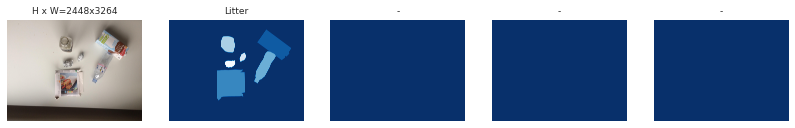

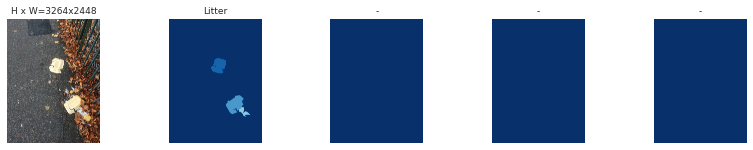

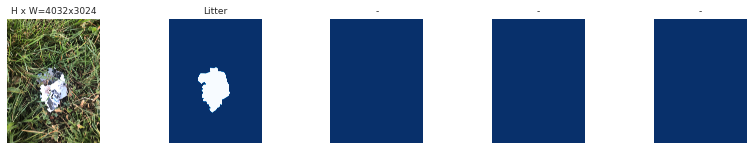

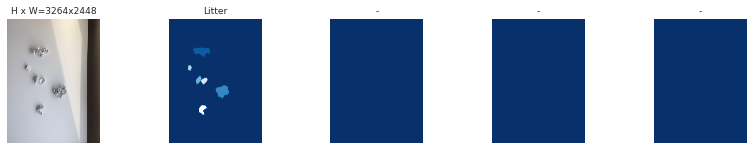

In [29]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

[1 1 1 1]
image_id  522 
image                    shape: (4032, 3024, 3)       min:    0.00000  max:  255.00000  uint8


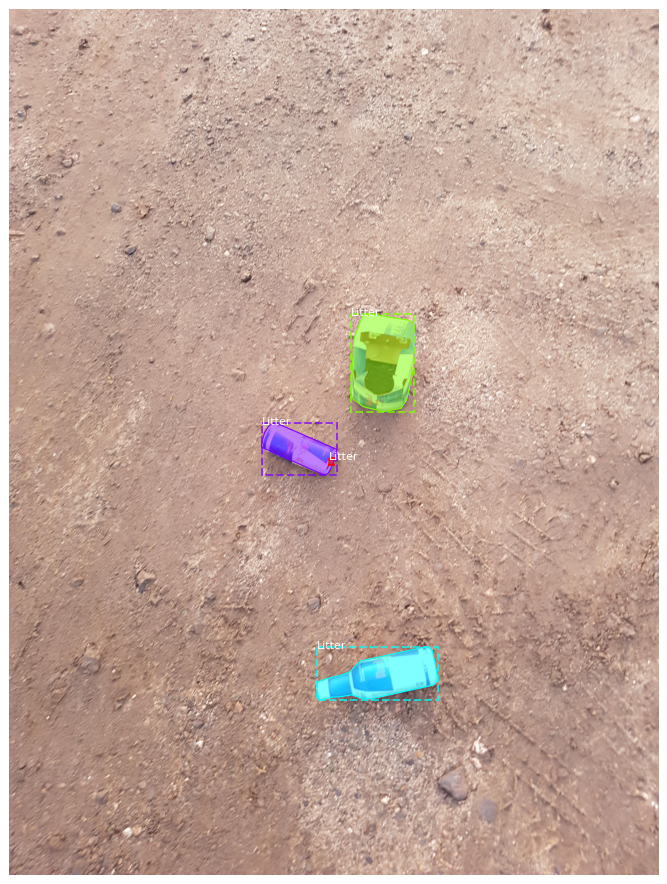

In [30]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
print(class_ids)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
# log("mask", mask)
# log("class_ids", class_ids)
# log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [11]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  1456 
Original shape:  (3264, 2448, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (4, 4)                min:   39.00000  max:  723.00000  int32


/home/joshlo/Downloads/TACO-master/detector/visualize.py:169: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

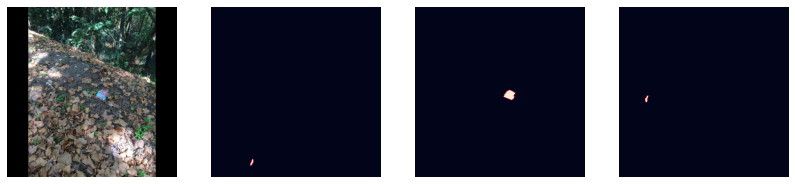

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  246.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 3264.00000  int64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   10.00000  max:  886.00000  int32
mask                     shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


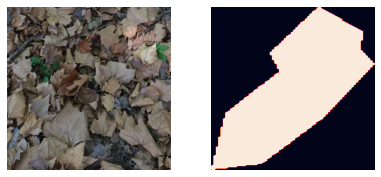

In [28]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=True)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

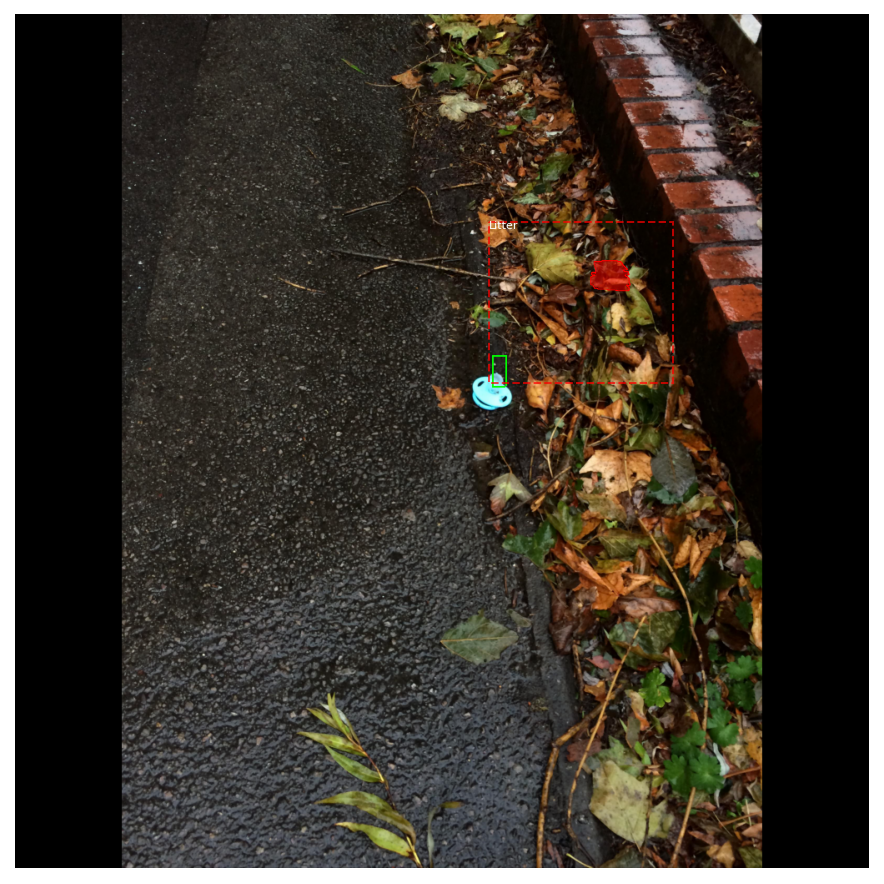

In [53]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


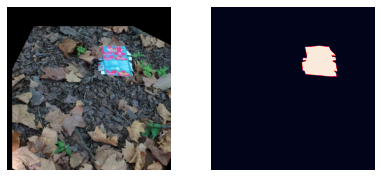

In [30]:
# Add augmentation and mask resizing.

# Image Augmentation Pipeline
aug_pipeline = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
    iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
    # iaa.Dropout([0.0, 0.05], name='Dropout'), # drop 0-5% of all pixels
    iaa.Fliplr(0.5),
    iaa.Add((-20, 20),name="Add"),
    iaa.Multiply((0.8, 1.2), name="Multiply"),
    iaa.Affine(scale=(0.8, 2.0)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
    iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
], random_order=True)
    
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, aug_pipeline, use_mini_mask=False)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

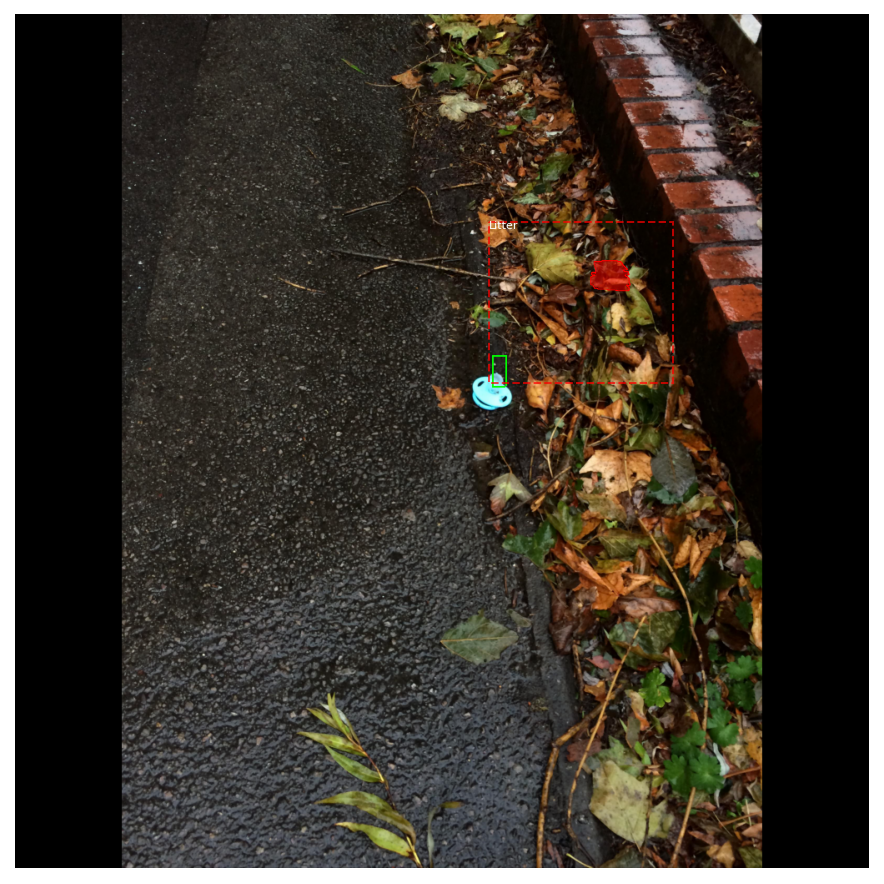

In [52]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [31]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

print(backbone_shapes)
# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

[[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
[489.372583  500.6862915 534.627417  523.3137085]
[496. 496. 528. 528.]
[500.6862915 489.372583  523.3137085 534.627417 ]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
[466.745166 489.372583 557.254834 534.627417]
[480. 480. 544. 544.]
[489.372583 466.745166 534.627417 557.254834]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
[421.49033201 466.745166   602.50966799 557.254834  ]
[448. 448. 576. 576.]
[466.745166   421.49033201 557.254834   602.50966799]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
[330.98066402 421.49033201 693.01933598 602.50966799]
[384. 384. 640. 640.]
[421.49033201 330.98066402 602.50966799 693.01933598]
Level 4. Anchors:    768  Feature map Shape: [16 16]
[149.96132803 330.98066402 874.03867197 693.01933598]
[256. 256. 768. 768.]
[330.98066402 149.96132803 693.01933598 874.03867197]


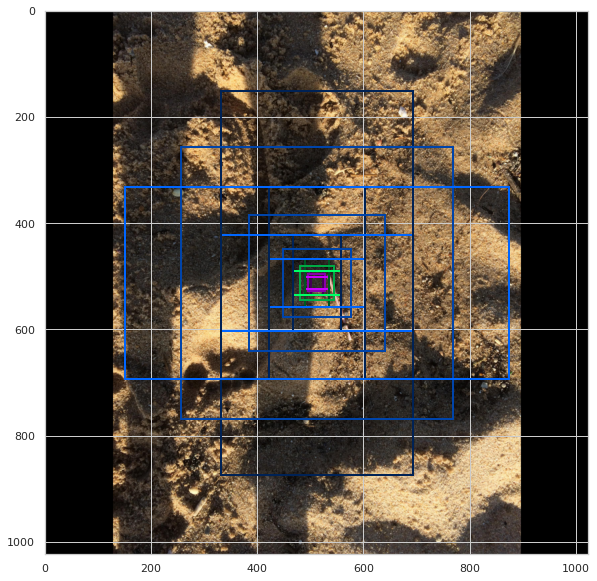

In [32]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
#     level_center = int(center_anchor)
    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)
        print(rect)


## Data Generator


In [43]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [44]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
for i in range(10):
    print(i)
    _, _ = next(g)

0


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


2


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


3


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


4


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


5


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


6


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

7


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


8


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


9


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

In [45]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.35209  max:    3.27206  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  996.00000  int32
gt_masks                 shape: (4, 1024, 1024, 100)  min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:  -10.10275  max:    3.75650  float64
image_id:  1058 


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (1, 4)                min:  431.00000  max:  596.00000  float32
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 261632
BG                     : 184
Litter                 : 16


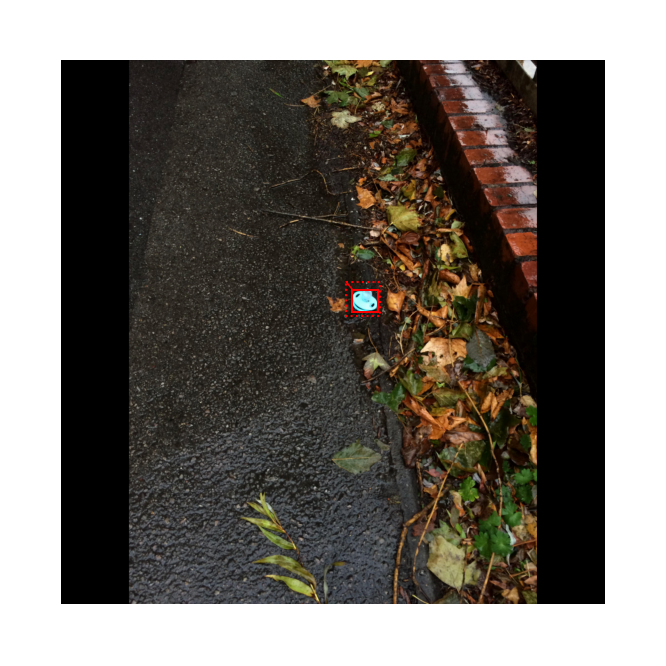

In [46]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

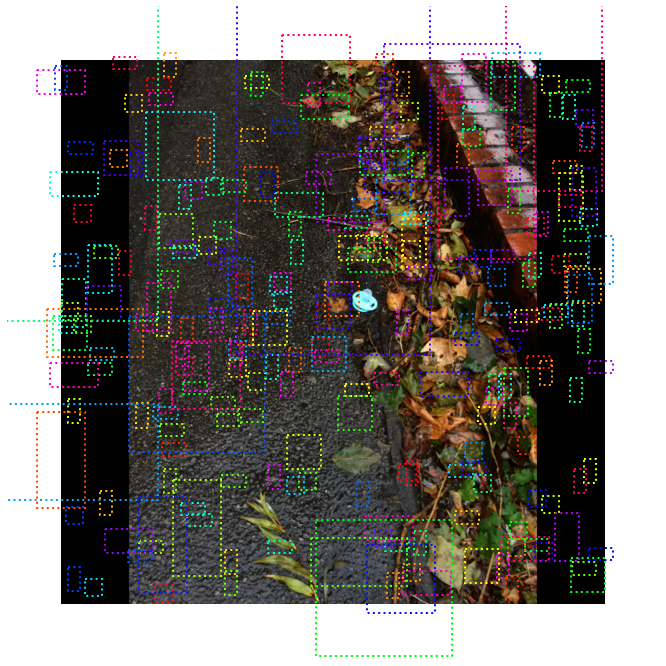

In [47]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

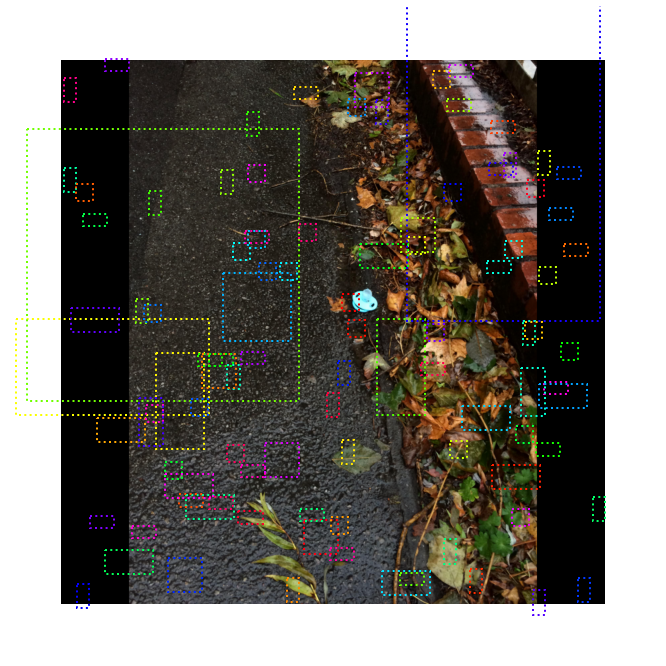

In [48]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  16
Negative ROIs:  184
Positive Ratio: 0.08
Unique ROIs: 200 out of 200


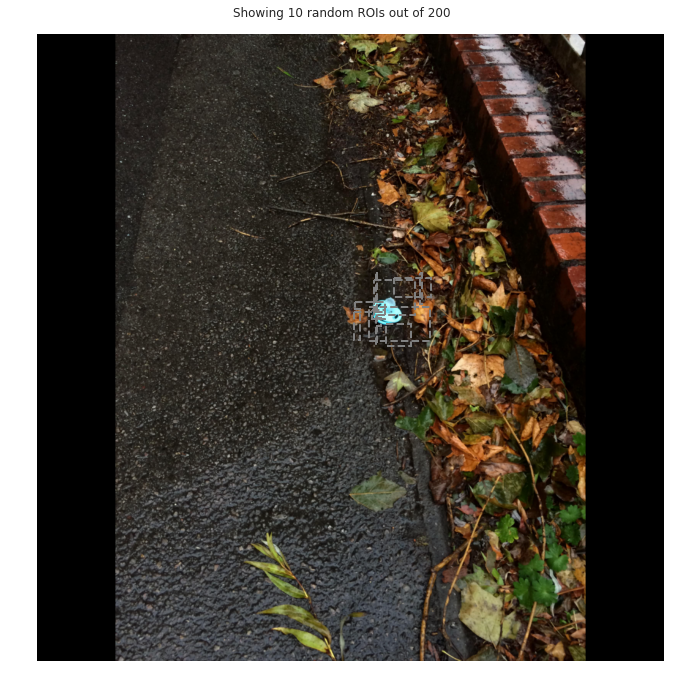

In [49]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

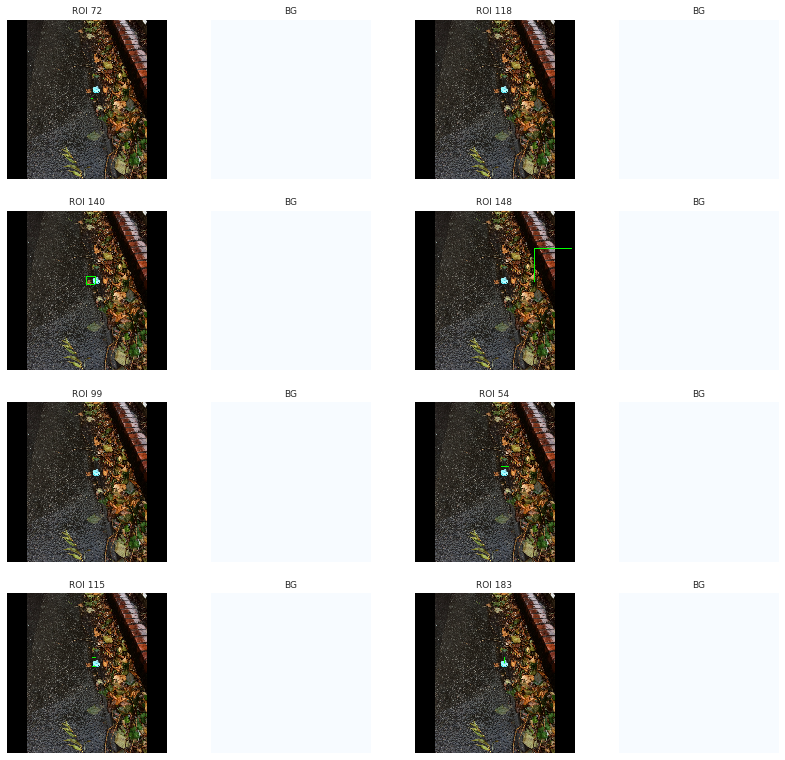

In [50]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [51]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   66  0.33


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   66  0.33
   66  0.33


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   66  0.33
   66  0.33


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   66  0.33
   66  0.33


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   66  0.33


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   66  0.33
   66  0.33
Average percent: 0.33


/home/joshlo/enter/envs/Mask_RCNN/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
